# А/А тестирование мобильного приложения

Задача:

Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

In [1]:
#подгружаем все необходимые библиотеки

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
#чтение файла

df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';')

Описание колонок:

experimentVariant – вариант эксперимента

version – версия приложения

purchase – факт покупки

In [3]:
#проверим, что содержимое колонок отображается корректно

df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
#посмотрим на уникальные значения в колоке типа эксперимента

df.experimentVariant.unique()

array([1, 0])

In [5]:
#и на уникальные занчения переменной отражающей факт покупки

df.purchase.unique()

array([0, 1])

In [6]:
#проверим, что типы данных соответсвуют необходимым, чтобы можно было начнать анализ

df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

# Первичный A/A тест

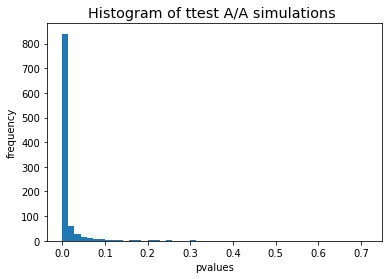

In [7]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [8]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.937

Значение FPR > 0.05, A/A тест не сходитя.

# Выявление причины

Чтобы найти причину, посчитаем конверсию по каждой из версий приложения.

In [9]:
df.groupby('version').agg({'purchase':'mean'})

,purchase
version,
v2.8.0,0.023372
v2.9.0,0.072973
v3.7.4.0,0.061484
v3.8.0.0,0.060319


Поскульку величина конверсии по версии приложения "v2.8.0" более чем в два раза отличается от конверсии любой другой версии, можно предположить, что поломка случилась именно в этом источнике.

Чтобы проверить допущение разобъем данные и по типу эксперименту и по версии приложения, и посчитаем конверсию для каждой из групп.

In [10]:
df.groupby(['version', 'experimentVariant']).agg({'purchase':'mean'})

purchase
version  experimentVariant          
v2.8.0   0                  0.000993
         1                  0.045606
v2.9.0   0                  0.074658
         1                  0.071304
v3.7.4.0 0                  0.059943
         1                  0.063018
v3.8.0.0 0                  0.057604
         1                  0.062848

Видно, что значение конверсии для версии "v2.8.0" сильно различаются в зависмости от экспериментальной группы.

In [11]:
#проверим объемы выборок для каждой из грпупп

df.groupby(['version', 'experimentVariant']).agg({'uid':'count'})

uid
version  experimentVariant       
v2.8.0   0                  41283
         1                  41552
v2.9.0   0                  11921
         1                  12033
v3.7.4.0 0                   4204
         1                   4221
v3.8.0.0 0                   5694
         1                   6110

Поскольку объемы экспериментальных групп для версии "v2.8.0" приблизительно равны, а конверсии сильно различаются, назначаем эту область проблемной и исключаем её из эксперимента.

# Повторный A/A тест

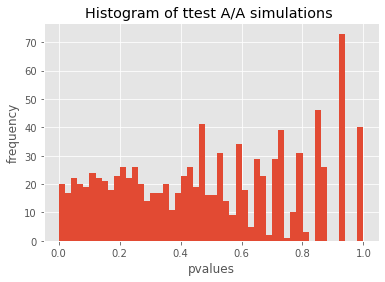

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 1 & version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 0 & version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [13]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.046

Значение FPR < 0.05, A/A тест сходитя.

# Вывод

Причну поломки сплит-системы стоит искать в версии приложения v2.8.0.